In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import transformers

from torch import cuda
from transformers import DistilBertModel, DistilBertTokenizer

from DistillBERTClass import DistillBERTClass
from Util import category_list

from IPython.display import display, clear_output

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report,cohen_kappa_score, f1_score

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
TOKEN_PATH = '../models/vocab_distilbert_amazon_weighted_eval.bin'
MODEL_PATH = '../models/pytorch_distilbert_amazon_weighted_eval.bin'
TESTSET_PATH = '../datasets/cleaned/test_set_for_evaluating_bert.csv'
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
test_df = pd.read_csv(TESTSET_PATH)
test_texts = list(test_df['text'])
test_labels = list(test_df['label'])

In [4]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(TOKEN_PATH)

model = DistillBERTClass()
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

Calling DistilBertTokenizer.from_pretrained() with the path to a single file or url is deprecated


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [5]:
def batch_predict(model, text_list):
    predictions, energies = [], []
    n = 0
    text_list_len = len(text_list)
    for text in text_list:
        clear_output(wait=True)
        display(f"Iteration: {n} / {text_list_len}")
        inputs = tokenizer.encode_plus(text, return_tensors="pt", add_special_tokens=True, max_length=512)
        model.eval()
        with torch.no_grad():
            ids = inputs['input_ids'].to(device, dtype = torch.long)
            mask = inputs['attention_mask'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask)

        big_val, big_idx = torch.max(outputs.data, dim=1)
        
        predictions.append(big_idx[0].item())
        energies.append(list(outputs.cpu().data.numpy()[0]))
        n += 1

    return predictions, energies

In [6]:
%%time
predictions, energies = batch_predict(model, test_texts)

'Iteration: 127100 / 127101'

Wall time: 16min 52s


In [4]:
test_df

,Unnamed: 0,text,category,label
0,0,can I replace Badger 1 1/3 with a Badger 5 1/2...,appliances,0
1,1,Can someone tell me if this Badger 5 disposer ...,appliances,0
2,2,My present disposal has a 3 bolt connection. W...,appliances,0
3,3,can you bake corn bread on this without it bur...,appliances,0
4,4,"I need a device to let my dryer vent out, I li...",appliances,0
...,...,...,...,...
127096,127096,How do I get this to work for two players on p...,video_games,20
127097,127097,how many gig on the hard drive It is a 500gb h...,video_games,20
127098,127098,Does the kinect-less version still play blu ra...,video_games,20
127099,127099,Are there offline options for the games for Xb...,video_games,20


In [7]:
evaluation_data = pd.DataFrame({
    'prediction': predictions,
    'true': test_labels,
    'energy': energies,
    'text': tex
})

In [8]:
evaluation_data.to_csv('../datasets/bert_predictions/bert_predictions_weighted.csv', index=False)

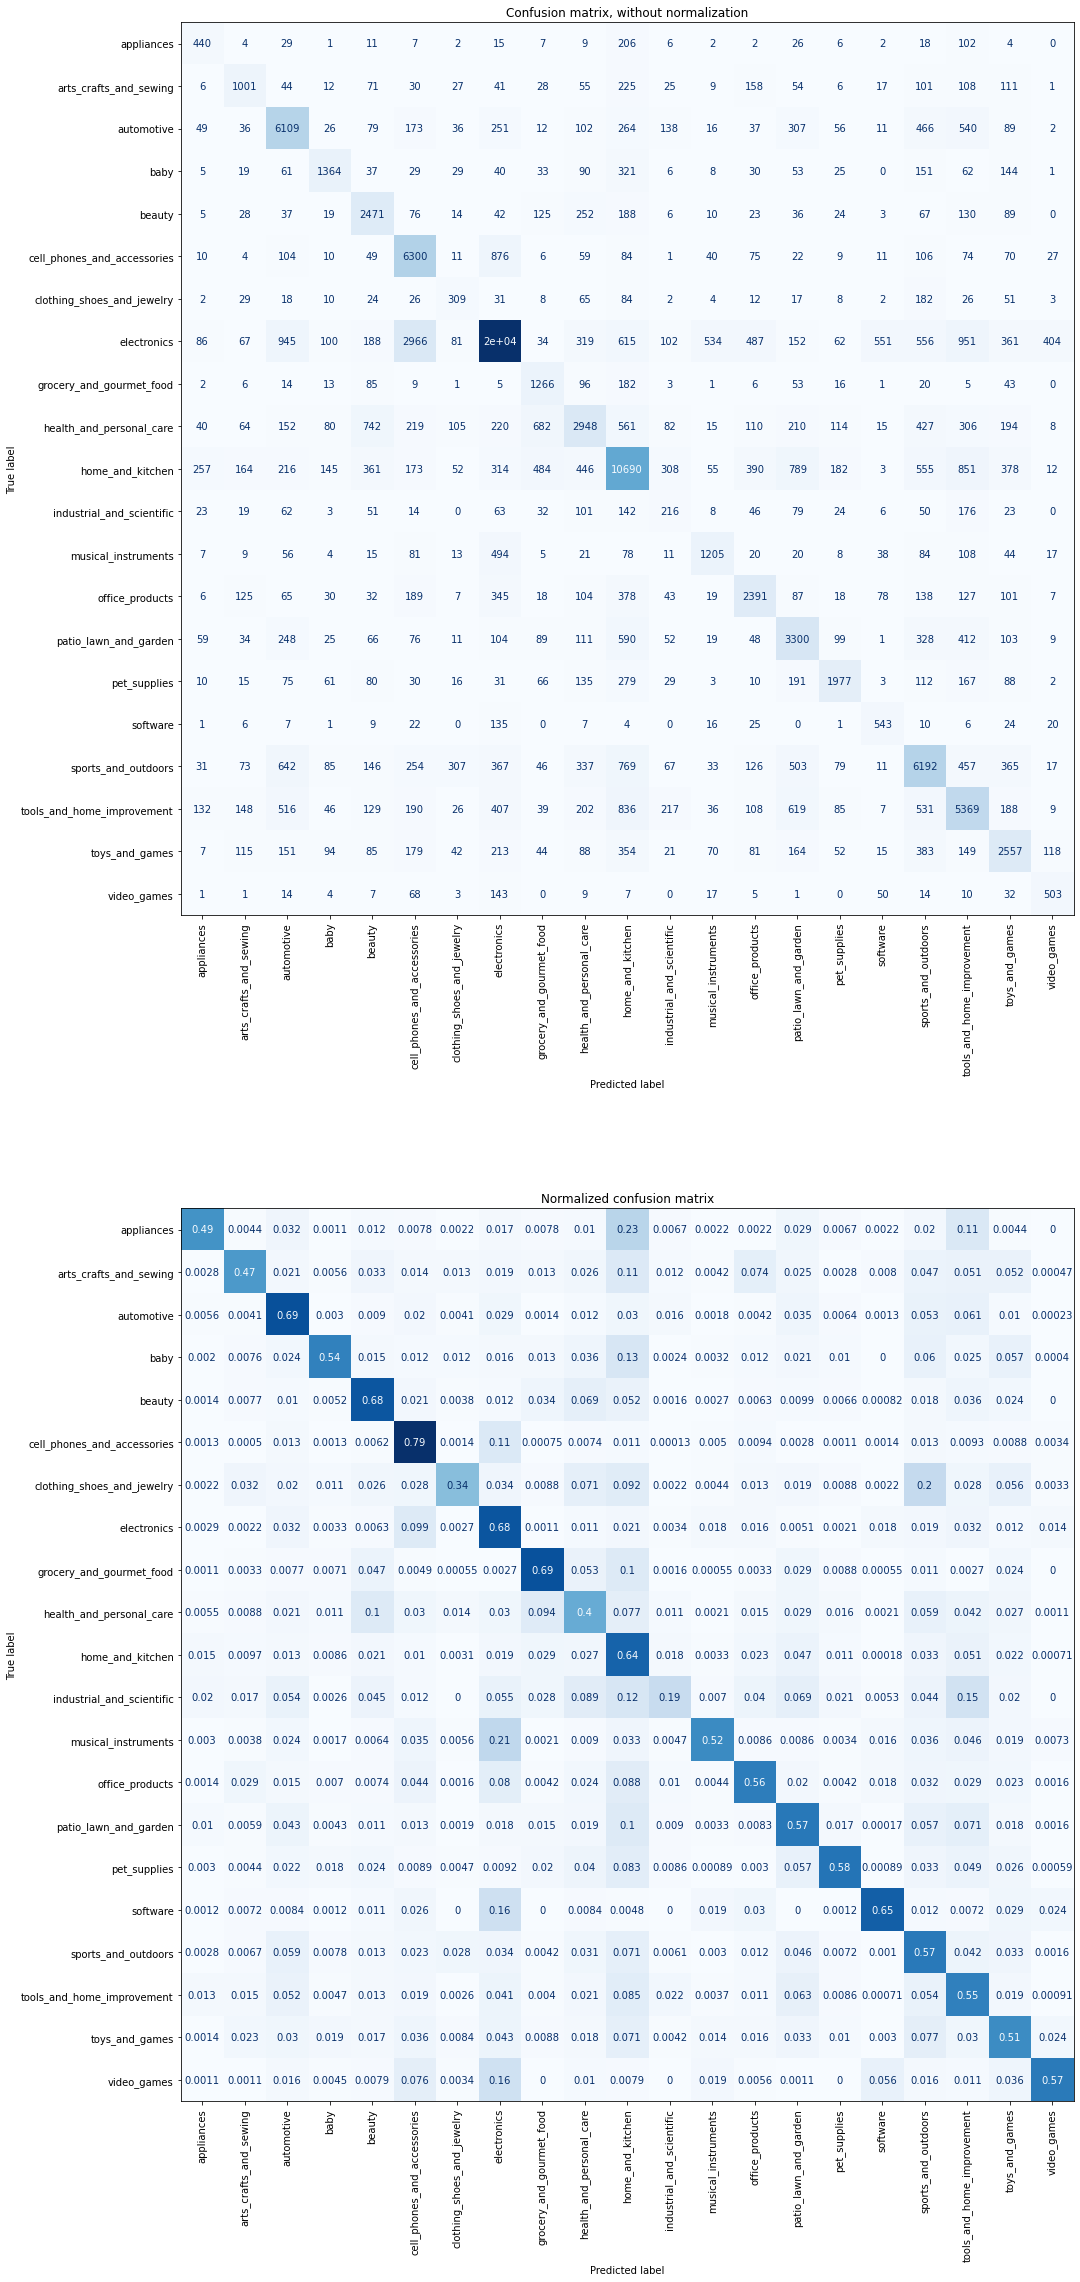

In [9]:
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax = plt.subplots(2, 1, figsize=(20, 40))
i = 0
for title, normalize in titles_options:
    cm = confusion_matrix(
        [category_list[i] for i in evaluation_data['true']], 
        [category_list[i] for i in evaluation_data['prediction']], 
        labels=category_list,
        normalize=normalize)
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=category_list)

    ax[i] = disp.plot(
        include_values=True,
        cmap=plt.cm.Blues, 
        ax=ax[i], 
        xticks_rotation='vertical')
    
    ax[i].ax_.set_title(title)
    ax[i].ax_.images[0].colorbar.remove()
    i+=1

plt.show()

In [10]:
report = classification_report(
    y_true = list(evaluation_data['true']), 
    y_pred = list(evaluation_data['prediction']),
    labels=list(range(21)),
    target_names=category_list)
print(report)

                             precision    recall  f1-score   support

                 appliances       0.37      0.49      0.42       899
     arts_crafts_and_sewing       0.51      0.47      0.49      2130
                 automotive       0.64      0.69      0.67      8799
                       baby       0.64      0.54      0.59      2508
                     beauty       0.52      0.68      0.59      3645
cell_phones_and_accessories       0.57      0.79      0.66      7948
 clothing_shoes_and_jewelry       0.28      0.34      0.31       913
                electronics       0.83      0.68      0.75     29910
   grocery_and_gourmet_food       0.42      0.69      0.52      1827
   health_and_personal_care       0.53      0.40      0.46      7294
           home_and_kitchen       0.63      0.64      0.63     16825
  industrial_and_scientific       0.16      0.19      0.17      1138
        musical_instruments       0.57      0.52      0.54      2338
            office_products      

For imbalanced learning, recall is typically used to measure the coverage of the minority class.

cohen kappa:

$\kappa = (p_o - p_e) / (1 - p_e)$

The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement.

In [11]:
cohen_kappa_score(
    y1 = list(evaluation_data['true']),
    y2 = list(evaluation_data['prediction']),
    labels=list(range(21)),
)

0.5675123951453591

In [16]:
f1_score(
    y_true = list(evaluation_data['true']),
    y_pred = list(evaluation_data['prediction']),
    labels=list(range(21)),
    average='micro'
)

0.6097513001471271